In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

sys.path.insert(0, os.path.abspath('../src'))

# Now you can import the classes
from reactor import Reaction
from diffusion import Reaction_Diffusion

import re
import duckdb
connection = duckdb.connect(database=':memory:', read_only=False)
from tqdm import tqdm

# Preparations

## Calc adsorption

From Site Densities, Rates, and Mechanism of Stable Ni/UiO-66 Ethylene Oligomerization Catalysts  
https://pubs.acs.org/doi/10.1021/jacs.1c09320?fig=fig1&ref=pdf  
https://pubs.acs.org/doi/10.1021/acssuschemeng.8b05524

In [2]:
k = 1.38e-23
T = 473
h = 6.626e-34
R = 8.314
ccal_j = 4184

Eyrin_k = lambda G: k * T / h * np.exp(-G * ccal_j/(R * T)) 
k_insertion, k_insertion_b = Eyrin_k((28.4 + 51.1)/4.184), Eyrin_k((28.4 + 77.6)/4.184)

diffusions = np.array([4.010918e-08, 1.324638e-08])
L = 20 #nm
n = L/3
flux = diffusions / (L * 1e-9)
k_insertion, k_insertion_b, flux
'{:8.3e}'.format(Eyrin_k((57/4.184)))

'4.996e+06'

In [3]:
from scipy.optimize import minimize

def run_reactions(reactions, capcacity=None):
    r = Reaction_Diffusion(reactions, capacity=capcacity, fixed_concentrations={'C2': 0.094})
    start_time = 0
    end_time = 100*1e3
    n_steps = int(1e5)
    df = r.solve({'Cat': 4.1e-4, 'C2': 0.094}, np.linspace(start_time, end_time, n_steps))
    return df


def trimer(k_adsorbtion, k_desorbtion):
    reactions = [            
            ['Cat + C2 <-> CatC2', k_adsorbtion, k_desorbtion],
            ['CatC2 + C2 <-> CatC4', k_insertion, k_insertion_b],
            ['CatC4 + C2 <-> CatC6', k_insertion, k_insertion_b],

            ['CatC4 <-> Cat + C4', k_desorbtion, k_adsorbtion],
            ['CatC6 <-> Cat + C6', k_desorbtion, k_adsorbtion],

            ['C4 D> C4_out', flux[0], flux[0]],
            ['C6 D> C6_out', flux[1], flux[1]],
            ]
    
    trimer_calc = run_reactions(reactions, {'C4': 1, 'C6': 1, 'C4_out': 1, 'C6_out': 1})
    c4 = trimer_calc['C4'].values + trimer_calc['C4_out'].values
    c6 = trimer_calc['C6'].values + trimer_calc['C6_out'].values
    return c4, c6, trimer_calc.index


def func(x):
    c4, c6, _ = trimer(x[0], x[1])
    error = (c4[-1]/c6[-1] - 0.94/0.06) ** 2
    return error

# Initial guess for the parameters
initial_point = np.array([5e6, 1e4])
bounds = [(1e-4, 1e7), (1e-4, 1e6)]
# Perform the minimization using the Nelder-Mead method
result = minimize(
    fun=func,
    x0=initial_point,
    method='L-BFGS-B',  # L-BFGS-B optimization method
    bounds=bounds,      # Adding bounds to the optimizer
    options={'maxiter': 200, 'disp': True}  # Set maximum iterations
)
result.x, func(result.x)

(array([4999999.99999996,    9999.99999994]), 197.39907019648757)

<Axes: xlabel='time'>

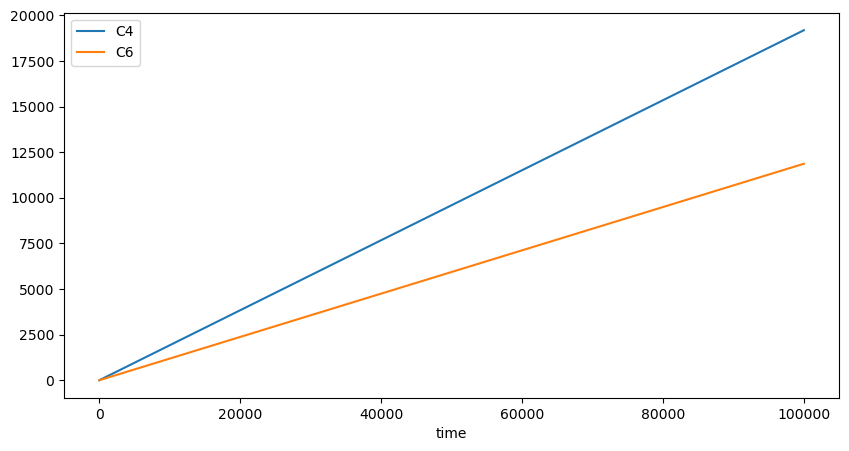

In [4]:
c4, c6, time = trimer(result.x[0], result.x[1])

trimer_calc = pd.DataFrame({'C4': c4, 'C6': c6, 'time': time})
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
trimer_calc.plot(x='time', y='C4', ax=ax, label='C4')
trimer_calc.plot(x='time', y='C6', ax=ax, label='C6')

## Prepare capcacity

In [5]:
# prep capcaity
capacity_df = pd.read_parquet(r'C:\Users\lt0828\Desktop\PhD\p3\nu1000_model\gcmc\files\trappe_ff\mix.parquet')
capacity_df = capacity_df.loc[:, ['p', 'temperature', 'adsorption_type', 'mol_uc_avg', 'component_num']]
capacity_df = capacity_df.astype({'p': int, 'temperature': int, 'component_num': int, 'mol_uc_avg': float,
                                  'adsorption_type': 'category'})

capacity_df['alken'] = capacity_df['component_num'].apply(lambda x: f'C{(x+1)*2}').astype(str) + \
                            capacity_df['adsorption_type'].apply(lambda x: '' if x == 'absolute' else '_out').astype(str)
print(capacity_df.shape)
s = """
with t1 as (
SELECT * FROM capacity_df where adsorption_type = 'absolute'),
t2 as (
SELECT * FROM capacity_df where adsorption_type = 'excess'),
t3 as (
select t2.*, t1.mol_uc_avg - t2.mol_uc_avg as capacity from t1 join t2 on t1.temperature = t2.temperature 
and t1.component_num = t2.component_num and t1.p = t2.p)

select *, mol_uc_avg as capacity from capacity_df where adsorption_type = 'absolute'
union
select t3.*from t3
order by temperature, p, component_num, adsorption_type
"""
capacity_df = connection.execute(s).fetchdf()
capacity_df.query('temperature == 300 and p == 100000').head(2)

(1210, 6)


,p,temperature,adsorption_type,mol_uc_avg,component_num,alken,capacity
0,100000,300,absolute,1.554528,0,C2,1.554528
1,100000,300,excess,1.458681,0,C2_out,0.095847


In [5]:
distribution = pd.read_pickle(r'C:\Users\lt0828\Desktop\PhD\p3\nu1000_model\gcmc\files\clusterization\distribution.pkl')\
    .drop(columns=['atom_name']).rename(columns={'T': 'temperature'})
distribution['alken'] = distribution['n'].apply(lambda x: f'C{x}').astype(str)
distribution = distribution[~distribution.file.str.contains('lowT')]
s = '''
with t1 as (
select * from distribution where cluster = 0),
t2 as (
    select d.*, d.N_mol / t1.N_mol as ratio from distribution as d
    left join t1 using(alken, p, temperature))

select * from t2 where cluster == 1
'''
distribution_df = connection.execute(s).fetchdf()
distribution_df

,file,cluster,N_mol,p,temperature,n,G,alken,ratio
0,mixtures_hf/p_100000_T_300/Movies/System_0/Mov...,1,174113,100000,300,2,-0.147839,C2,1.281458
1,mixtures_hf/p_100000_T_300/Movies/System_0/Mov...,1,3830784,100000,300,4,0.083982,C4,0.868594
2,mixtures_hf/p_100000_T_300/Movies/System_0/Mov...,1,2012997,100000,300,6,0.366908,C6,0.540379
3,mixtures_hf/p_100000_T_300/Movies/System_0/Mov...,1,360236,100000,300,8,0.445957,C8,0.473270
4,mixtures_hf/p_100000_T_300/Movies/System_0/Mov...,1,74278,100000,300,10,0.427071,C10,0.488504
...,...,...,...,...,...,...,...,...,...
603,mixtures_hf/p_100000_T_390/Movies/System_0/Mov...,1,365885,100000,390,8,1.219507,C8,0.207292
604,mixtures_hf/p_5000000_T_570/Movies/System_0/Mo...,1,858846,5000000,570,2,-0.416375,C2,1.444283
605,mixtures_hf/p_3530000_T_330/Movies/System_0/Mo...,1,8885,3530000,330,10,1.277172,C10,0.142605
606,mixtures_hf/p_5000000_T_420/Movies/System_0/Mo...,1,3479528,5000000,420,2,-0.391516,C2,1.598583


In [6]:
distribution_df.to_pickle('files/distribution_df.pkl')
capacity_df.to_pickle('files/capacity_df.pkl')

# Run model

In [2]:
def calculate_metrix(df):
    dft = df.query('n > 2').copy()
    dft['probability'] = dft['concentration'] / dft['concentration'].sum()
    mean = (dft['n'] * dft['probability']).sum()
    std = np.sqrt((dft['n']**2 * dft['probability']).sum() - mean**2)

    return {'mean': mean, 'std': std}

def run_reactions(reactions, capcacity, hours):
    r = Reaction_Diffusion(reactions, capacity=capcacity)
    start_time = 0
    end_time = 60 * 60 * hours
    n_steps = int(1e5)
    df = r.solve({'Cat': 1e-6, 'C2': 100}, np.linspace(start_time, end_time, n_steps))
    df = df.filter(regex='^C\d+').iloc[n_steps-1000:]
    df = df.mean()
    df = df.reset_index(name='concentration')
    df['n'] = df['index'].str.extract(r'(\d+)').astype(int)
    
    metrix = calculate_metrix(df)

    df = df.assign(alken=df.n.apply(lambda x: f'C{x}H{2*x}')).groupby('alken').concentration.sum().reset_index()
    df['n'] = df.alken.str.extract(r'(\d+)').astype(int)
    df = df.sort_values('n')
    return df, metrix


k_insertion, k_insertion_b = 2.72e-02, 7.21e-07
k_adsorbtion, k_desorbtion = 1e5, 1e5
diffusions = np.array([4.010918e-08, 1.324638e-08, 4.875015e-09, 2.026042e-09, 1.026042e-09, 2.767088e-10])

L = 20 #nm
n = L/3
flux = diffusions / (L * 1e-9)

pressure = [100000]#,  590000, 1080000, 1570000, 2060000, 2550000, 3040000,
        # 3530000, 4020000, 4510000, 5000000]
temperature = [300]#, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600]
capacity_df = pd.read_pickle('files/capacity_df.pkl')
distribution_df = pd.read_pickle('files/distribution_df.pkl')

result = []
with tqdm(total=len(temperature) * len(pressure) * 2 * 2) as pbar:
    for T in temperature:
        for p in pressure:
            for location in True, False:
                for hours in [5, 100]:
                    capcacity = capacity_df.query(f'temperature == {T} and p == {p}').set_index('alken')['capacity'].to_dict()
                    gg = distribution_df.query(f'temperature == {T} and p == {p}')\
                    .sort_values('n')
                    ratio_dict = gg.set_index('alken')['ratio'].to_dict()
                    for i, j in ratio_dict.items():
                        ratio_dict[i] = 1/(1 + j)
                        if location:
                            ratio_dict[i] = 1 - 1/(1 + j)

                    reactions = [            
                                ['Cat + C2r <-> CatC2', k_adsorbtion, k_desorbtion],
                                ['CatC2 + C2r <-> CatC4', k_insertion, k_insertion_b],
                                ['CatC4 + C2r <-> CatC6', k_insertion, k_insertion_b],
                                ['CatC6 + C2r <-> CatC8', k_insertion, k_insertion_b],
                                ['CatC8 + C2r <-> CatC10', k_insertion, k_insertion_b],
                                ['CatC4 <-> Cat + C4r', k_desorbtion, k_adsorbtion],
                                ['CatC6 <-> Cat + C6r', k_desorbtion, k_adsorbtion],
                                ['CatC8 <-> Cat + C8r', k_desorbtion, k_adsorbtion],
                                ['CatC10 <-> Cat + C10r', k_desorbtion, k_adsorbtion],

                                ['C2 <D> C2_out', flux[0], flux[0]],
                                ['C4 <D> C4_out', flux[1], flux[1]],
                                ['C6 <D> C6_out', flux[2], flux[2]],
                                ['C8 <D> C8_out', flux[3], flux[3]],
                                ['C10 <D> C10_out', flux[4], flux[4]],
                                ['C2r <D> C2_out', flux[0], flux[0]],
                                ['C4r <D> C4_out', flux[1], flux[1]],
                                ['C6r <D> C6_out', flux[2], flux[2]],
                                ['C8r <D> C8_out', flux[3], flux[3]],
                                ['C10r <D> C10_out', flux[4], flux[4]],
                                ['C2 <D> C2r', flux[0]*n, flux[0]*n],
                                ['C4 <D> C4r', flux[1]*n, flux[1]*n],
                                ['C6 <D> C6r', flux[2]*n, flux[2]*n],
                                ['C8 <D> C8r', flux[3]*n, flux[3]*n],
                                ['C10 <D> C10r', flux[4]*n, flux[4]*n],
                                ]
                    for cnt, i in enumerate(range(2, 11, 2)):
                        capcacity[f'C{i}r'] = capcacity[f'C{i}'] * ratio_dict[f'C{i}']
                        capcacity[f'C{i}'] = capcacity[f'C{i}'] * (1-ratio_dict[f'C{i}'])

                    df, metrix = run_reactions(reactions, capcacity, hours=hours)
                    df['temperature'] = T
                    df['p'] = p
                    df['location'] = location
                    df['mean'] = metrix['mean']
                    df['std'] = metrix['std']
                    df['hours'] = hours
                    result.append(df)
                    pbar.update(1)

result = pd.concat(result).reset_index(drop=True)
result#['mean']. describe()

100%|██████████| 4/4 [00:00<00:00, 13.95it/s]


,alken,concentration,n,temperature,p,location,mean,std,hours
0,C2H4,9.994942e+01,2,300,100000,True,4.000250,0.022358,5
1,C4H8,2.528266e-02,4,300,100000,True,4.000250,0.022358,5
2,C6H12,3.159866e-06,6,300,100000,True,4.000250,0.022358,5
3,C8H16,1.291069e-10,8,300,100000,True,4.000250,0.022358,5
4,C10H20,2.650878e-15,10,300,100000,True,4.000250,0.022358,5
5,C2H4,9.899445e+01,2,300,100000,True,4.004446,0.094229,100
6,C4H8,5.011012e-01,4,300,100000,True,4.004446,0.094229,100
7,C6H12,1.115519e-03,6,300,100000,True,4.004446,0.094229,100
8,C8H16,4.417771e-07,8,300,100000,True,4.004446,0.094229,100
9,C10H20,3.568219e-11,10,300,100000,True,4.004446,0.094229,100


In [5]:
s = '''
with t1 as (
select temperature, p, location, hours, count(*) as cnt, sum(concentration) as total_con from result where n > 2
group by temperature, p, location, hours
),
t2 as (
select * from result
left join t1 using(temperature, p, location, hours))
select *, concentration/total_con as proba from t2
'''
result = connection.execute(s).fetchdf()

## Plotting

Text(0.52, 0.92, '$\\mathbf{B}$')

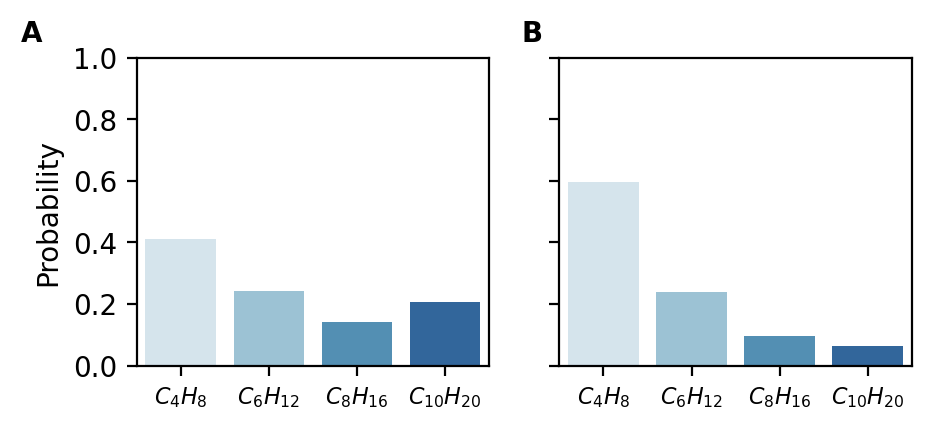

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(5, 2), dpi=200)

palette = ['#d1e5f0','#92c5de','#4393c3','#2166ac','#053061']  + \
['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7'][::-1] 

dft = result.query('hours == 3').copy()
sns.barplot(data=dft[(dft['mean'] == dft['mean'].max())][1:5], x='alken', y='proba', ax=axs[0],
            palette=palette)

sns.barplot(data=dft[dft['mean'] == dft['mean'].min()][1:5], x='alken', y='proba', ax=axs[1],
            palette=palette)

for i in axs:
    i.set_ylim(0, 1)
    i.set_xlabel('')

for i in range(2):
    axs[i].set_xticklabels([f'$C_{{{i*2}}}H_{{{i*4}}}$' for i in range(2, 6)], fontsize=8)
    axs[i].set_ylabel('Probability')
    axs[i].set_ylim([0, 1])
axs[1].set_ylabel('')
axs[1].set_yticklabels([])

x0, x1 = 0.02, 0.52
y0, y1 = 0.92, 0.45
fig.text(x0, y0, '$\mathbf{A}$', ha='center')
fig.text(x1, y0, '$\mathbf{B}$', ha='center')
# fig.text(x0, y1, '$\mathbf{C}$', ha='center')
# fig.text(x1, y1, '$\mathbf{D}$', ha='center')

In [66]:
s = '''
with t1 as (
    select * from result where mean = (select max(mean) from result where hours = 3)
    union
    select * from result where mean = (select min(mean) from result where hours = 3))
select temperature, p, location, hours, mean from t1
group by temperature, p, location, hours, mean
'''
connection.execute(s).fetch_df()

,temperature,p,location,hours,mean
0,480,5000000,False,3,5.260217
1,300,100000,True,3,6.286745


In [68]:
result.groupby(['temperature', 'p', 'hours', 'location']).head(1).sort_values(['temperature', 'p', 'hours', 'location'])

,alken,concentration,n,temperature,p,location,mean,std,hours,cnt,total_con,proba,cnt:1,total_con:1,proba_2
10,C2H4,99.986470,2,300,100000,False,5.913374,2.184391,3,4,0.004575,21853.185466,4,0.004575,21853.185466
0,C2H4,99.983238,2,300,100000,True,6.286745,2.326852,3,4,0.005332,18752.527914,4,0.005332,18752.527914
15,C2H4,99.891817,2,300,100000,False,5.913231,2.184246,24,4,0.036590,2730.047480,4,0.036590,2730.047480
5,C2H4,99.865979,2,300,100000,True,6.286261,2.326633,24,4,0.042639,2342.131329,4,0.042639,2342.131329
30,C2H4,99.991085,2,300,590000,False,5.359726,1.878158,3,4,0.003326,30061.785878,4,0.003326,30061.785878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2340,C2H4,99.899374,2,600,4510000,True,5.801765,2.132218,24,4,0.034688,2879.969893,4,0.034688,2879.969893
2355,C2H4,99.991224,2,600,5000000,False,5.342663,1.866699,3,4,0.003285,30440.012148,4,0.003285,30440.012148
2345,C2H4,99.987438,2,600,5000000,True,5.799435,2.131136,3,4,0.004332,23082.513826,4,0.004332,23082.513826
2360,C2H4,99.929817,2,600,5000000,False,5.342790,1.866723,24,4,0.026271,3803.739205,4,0.026271,3803.739205


# Justifying of the model

In [ ]:
k_insertion, k_insertion_b = 2.72e-02, 7.21e-07
k_adsorbtion, k_desorbtion = 1e-1, 1e-1
diffusions = np.array([4.010918e-08, 1.324638e-08, 4.875015e-09, 2.026042e-09, 1.026042e-09, 2.767088e-10])

L = 20 #nm

pressure = [100000,  590000, 1080000, 1570000, 2060000, 2550000, 3040000,
       3530000, 4020000, 4510000, 5000000][::3]

temperature = [300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600][::3]
result = []
with tqdm(total=len(temperature) * len(pressure) * 2 * 2 * 10) as pbar:
    for T in temperature:
        for p in pressure:
            for location in True, False:
                for hours in [10, 1e3]:
                    for k in np.linspace(1e-2, 1, 10):
                        k_adsorbtion = k
                        k_desorbtion = k
                        n = L/3
                        flux = diffusions / (L * 1e-9)
                        capcacity = capacity_df.query(f'temperature == {T} and p == {p}').set_index('alken')['capacity'].to_dict()

                        ratio = lambda G, T: np.exp(-G * 4184 / (8.314 * T))
                        x = np.linspace(-0.4, -2 * T/300., 5)
                        y = ratio(x, T)
                        y = 1/(1 + y)
                        if location:
                            y = 1 - y
                        reactions = [            
                                    ['Cat + C2r <-> CatC2', k_adsorbtion, k_desorbtion],
                                    ['CatC2 + C2r <-> CatC4', k_insertion, k_insertion_b],
                                    ['CatC4 + C2r <-> CatC6', k_insertion, k_insertion_b],
                                    ['CatC6 + C2r <-> CatC8', k_insertion, k_insertion_b],
                                    ['CatC8 + C2r <-> CatC10', k_insertion, k_insertion_b],
                                    ['CatC4 <-> Cat + C4r', k_desorbtion, k_adsorbtion],
                                    ['CatC6 <-> Cat + C6r', k_desorbtion, k_adsorbtion],
                                    ['CatC8 <-> Cat + C8r', k_desorbtion, k_adsorbtion],
                                    ['CatC10 <-> Cat + C10r', k_desorbtion, k_adsorbtion],

                                    ['C2 <D> C2_out', flux[0], flux[0]],
                                    ['C4 <D> C4_out', flux[1], flux[1]],
                                    ['C6 <D> C6_out', flux[2], flux[2]],
                                    ['C8 <D> C8_out', flux[3], flux[3]],
                                    ['C10 <D> C10_out', flux[4], flux[4]],
                                    ['C2r <D> C2_out', flux[0], flux[0]],
                                    ['C4r <D> C4_out', flux[1], flux[1]],
                                    ['C6r <D> C6_out', flux[2], flux[2]],
                                    ['C8r <D> C8_out', flux[3], flux[3]],
                                    ['C10r <D> C10_out', flux[4], flux[4]],
                                    ['C2 <D> C2r', flux[0]*n, flux[0]*n],
                                    ['C4 <D> C4r', flux[1]*n, flux[1]*n],
                                    ['C6 <D> C6r', flux[2]*n, flux[2]*n],
                                    ['C8 <D> C8r', flux[3]*n, flux[3]*n],
                                    ['C10 <D> C10r', flux[4]*n, flux[4]*n],
            ]
                        for cnt, i in enumerate(range(2, 11, 2)):
                            capcacity[f'C{i}r'] = capcacity[f'C{i}'] * (1-y[cnt])
                            capcacity[f'C{i}'] = capcacity[f'C{i}'] * (y[cnt])

                        df, metrix = run_reactions(reactions, capcacity, hours=hours)
                        df['temperature'] = T
                        df['p'] = p
                        df['location'] = location
                        df['mean'] = metrix['mean']
                        df['std'] = metrix['std']
                        df['hours'] = hours
                        df['k'] = k
                        result.append(df)
                        pbar.update(1)

result = pd.concat(result).reset_index(drop=True)
s = '''select stddev(mean) from result where alken = 'C2H4'
group by temperature, p, location, hours'''

dft = connection.execute(s).fetchdf()
dft.min(), dft.max()